## PER / PBR / 배당수익률 수준에 따른 수익률

In [1]:
import sys
import pandas as pd
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

sys.path.append('../')
from stock_screener.data_reader import *

In [2]:
# 최근 10년
begin_year = 2011
end_year = 2020

### 최근 10년에 대해 테스트
### 6월 마지막 거래일에 매수, 그 다음해 동월 마지막 거래일에 매도하는 식으로 시뮬레이션

In [3]:
# 6월 마지막 거래일 기준

dfs = []
for y in tqdm(range(begin_year, end_year + 1)):
    try:
        date = str(y) + '0630'
        df = get_per_pbr_dividend(date)
    except:
        try:
            date = str(y) + '0629'
            df = get_per_pbr_dividend(date)
        except:
            date = str(y) + '0628'
            df = get_per_pbr_dividend(date)
    dfs.append(df)

100%|██████████| 10/10 [00:32<00:00,  3.28s/it]


### PER / PBR / 배당수익률 각 지표를 기준으로, 종목을 10분위로 분할하여 테스트
#### i.e. 1분위(저PER)로만 포트폴리오 구성하는 전략, ..., 10분위(고PER)로만 포트폴리오 구성하는 전략

In [4]:
def get_rate_of_return_by_quantile(factor):

    num_split = 10
    ror_by_factor_level = dict()

    for year in range(begin_year, end_year):

        idx = year - begin_year
        df = dfs[idx].dropna() # PER, PBR, 배당수익률 기록 없는 기업 제외
        df = df.loc[df['PER'].apply(lambda x: x > 0)] # 영업이익 적자 제외
        
        if factor == '배당수익률':
            df = df.sort_values(factor, ascending=False)
        else:
            df = df.sort_values(factor)

        num_corp = len(df)
        for x in range(0, num_split):

            if x not in ror_by_factor_level:
                ror_by_factor_level[x] = []

            beg = x * (num_corp // num_split)
            end = (x+1) * (num_corp // num_split)
            _df = pd.merge(df[beg:end], dfs[idx+1], 
                          on=['종목명','종목코드'], 
                           how='left').fillna(0) # 거래정지, 상폐는 수익률 -100퍼로 간주한다
            rate_of_return = ((_df['종가_y'] - _df['종가_x']) / _df['종가_x']).mean()
            ror_by_factor_level[x].append(rate_of_return)

    quantile_idxs = []
    quantile_rors = []

    for k,v in ror_by_factor_level.items():
        v = np.array(v) + 1
        ror_mean = np.power(np.prod(v), 1/len(v)) - 1
        quantile_idxs.append(k)
        quantile_rors.append(ror_mean)
        
    return quantile_idxs, quantile_rors

#### PER 실험 결과

In [5]:
quantile_idxs, quantile_rors = get_rate_of_return_by_quantile('PER')

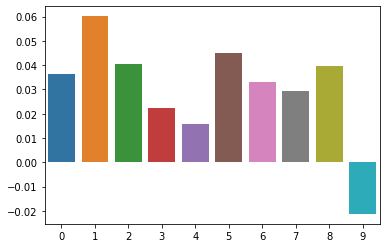

In [6]:
sns.barplot(quantile_idxs, quantile_rors, )

### PBR 실험 결과

In [7]:
quantile_idxs, quantile_rors = get_rate_of_return_by_quantile('PBR')

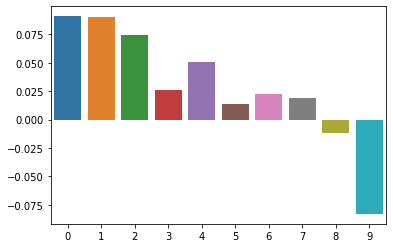

In [8]:
sns.barplot(quantile_idxs, quantile_rors)

#### 배당수익률 실험 결과

In [10]:
quantile_idxs, quantile_rors = get_rate_of_return_by_quantile('배당수익률')

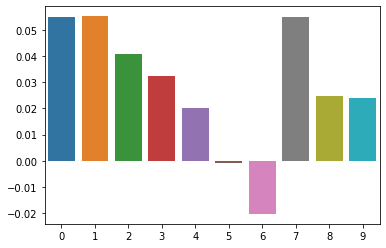

In [14]:
sns.barplot(quantile_idxs, quantile_rors)

### PBR이 가장 noise가 적은 지표이면서, 1분위수 그룹의 수익률도 높음(9%)